**Motivation**

The  motivation  behind developingmethods  for  face  recognition  at  long  distances  is  to  enable facial recognition technology in a broaderrange of applications. One of the main applications of facial  recognition  technology  is  in  security  and  surveillance  systems,  where  it  can  be  used  to identify  and  track  individuals  in real  time.  However,  traditional  facial  recognition  systems  are typically  limited  to  recognizing  faces  at  close  distances,  which  can  be  a  limitation  in specificenvironments such as airports, train stations, borders,and other public places where individuals are often far away from the camera.Overall, the development of methods for face recognition at long  distances  is  driven  by  the  need  to  improve facial  recognition  technology'saccuracy, efficiency, and scalability in a wide range of applications.

**Problem Statement and Overview**

Face recognition is thecomputer vision problem of finding the identityof human faces in digital images or video streams.

**Project Objectives**

Extend the original arcface loss function to improve its performance for the task of face recognition in long distances

**Dataset Description**

``DroneFace`` dataset is being used for this project. Below are some details about the dataset:

- 11 subjects including 7 males and 4 females.
- a total of 2,057 pictures including 620 raw images, 1,364 frontal face images, and 73 portrait images
- The raw images are taken in 3,680x2,760 resolution with ultra-wide field of view (170°) under daylights.
- The resolutions of the facial images are between 23x31 and 384x384.
- The raw images are taken from 1.5, 3, 4, and 5 meters high.
- The raw images are taken 2 to 17 meters away from the subjects with 0.5 meters interval.



## Data Preprocessing

In [1]:
# Import the libraries

import os
import shutil
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
#from sklearn.model_selection import train_test_split

from PIL import Image
from torchvision.transforms import ToPILImage
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer
import torch.nn.functional as F
#from sklearn.preprocessing import LabelEncoder

from model import Backbone

## Parse the data

In [2]:
# Navigate to the folder containing the images
faces_dir = "D:\OneDrive\Documents\GitHub Projects\Face Recognition Project\photos_all_faces"

# Define a list of persons (class labels)
persons = ['a','b','c','d','e','f','g','h','i','j','k']

# Determine the number of classes
num_classes = len(persons)

# Loop over each person
for person in persons:
    
    # Loop over each file in the faces directory
    for file in os.listdir(faces_dir):
        
        # If the file is a regular file and its name starts with the current person's name
        if os.path.isfile(os.path.join(faces_dir, file)) and file.startswith(person):
            
            # Get the first letter of the file name
            first_letter = file[0]
            
            # Construct the target directory path
            target_path = os.path.join(faces_dir, first_letter)
            
            # Create the target directory if it doesn't already exist
            os.makedirs(target_path, exist_ok=True)
            
            # Move the file to the target directory
            shutil.move(os.path.join(faces_dir, file), os.path.join(target_path, file))


In [4]:
# Set up test directory
# Manually create a subfolder called 'test' in the main directory 
# Move subfolders 'i,j,k' into 'test'
test_dir = "D:/OneDrive/Documents/GitHub Projects/Face Recognition Project/photos_all_faces/test"

# Load the test dataset
test_data = ImageFolder(root=test_dir)

# Print the class names
print(test_data.classes)

# Create empty lists for images and labels
test_images = []
test_labels = []

# Define the target image size
target_size = (112, 112)

# Loop over the dataset and append images and labels to the lists
for img, label in test_data:
    img = img.resize(target_size) # Resize the image
    img = transforms.ToTensor()(img) # Convert the image to a tensor
    test_images.append(img)
    test_labels.append(label)



['i', 'j', 'k']


In [29]:
test_classes = len(test_data.classes)
test_classes

3

In [5]:
test_images[:5]

[tensor([[[0.1098, 0.1098, 0.1176,  ..., 0.1647, 0.1686, 0.1686],
          [0.1137, 0.1137, 0.1176,  ..., 0.1608, 0.1647, 0.1647],
          [0.1255, 0.1216, 0.1216,  ..., 0.1451, 0.1490, 0.1490],
          ...,
          [0.0353, 0.0353, 0.0431,  ..., 0.1373, 0.1333, 0.1294],
          [0.0235, 0.0235, 0.0275,  ..., 0.1412, 0.1373, 0.1373],
          [0.0196, 0.0196, 0.0235,  ..., 0.1412, 0.1373, 0.1412]],
 
         [[0.1333, 0.1333, 0.1412,  ..., 0.1765, 0.1804, 0.1804],
          [0.1373, 0.1373, 0.1412,  ..., 0.1725, 0.1765, 0.1765],
          [0.1490, 0.1451, 0.1451,  ..., 0.1569, 0.1608, 0.1608],
          ...,
          [0.0275, 0.0353, 0.0392,  ..., 0.1216, 0.1176, 0.1137],
          [0.0157, 0.0196, 0.0235,  ..., 0.1255, 0.1216, 0.1216],
          [0.0118, 0.0157, 0.0157,  ..., 0.1255, 0.1216, 0.1255]],
 
         [[0.0863, 0.0863, 0.0941,  ..., 0.1490, 0.1529, 0.1529],
          [0.0902, 0.0902, 0.0941,  ..., 0.1451, 0.1490, 0.1490],
          [0.1020, 0.0980, 0.0980,  ...,

In [6]:
test_labels[:5]

[0, 0, 0, 0, 0]

In [7]:
test_labels[-5:]

[2, 2, 2, 2, 2]

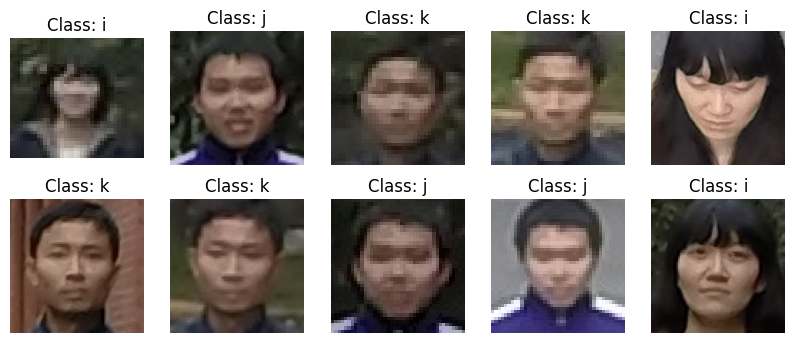

In [5]:
# Get 10 random images and labels from the test dataset
sample_indices = random.sample(range(len(test_data)), k=10)
sample_images = [test_data[i][0] for i in sample_indices]
sample_labels = [test_data[i][1] for i in sample_indices]

# Display the 10 random images
fig = plt.figure(figsize=(10, 4))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(sample_images[i])
    ax.set_title(f"Class: {test_data.classes[sample_labels[i]]}")
    ax.axis('off')
plt.show()



## Model Evaluation

### ROC Curve

ROC (Receiver Operating Characteristic) is a curve that plots the True Positive Rate (TPR) against the False Positive Rate (FPR) for different classification thresholds. The area under the ROC curve (AUC) is often used as a measure of the overall performance of a binary classification model. 

A higher AUC indicates a better model performance in distinguishing positive and negative samples.

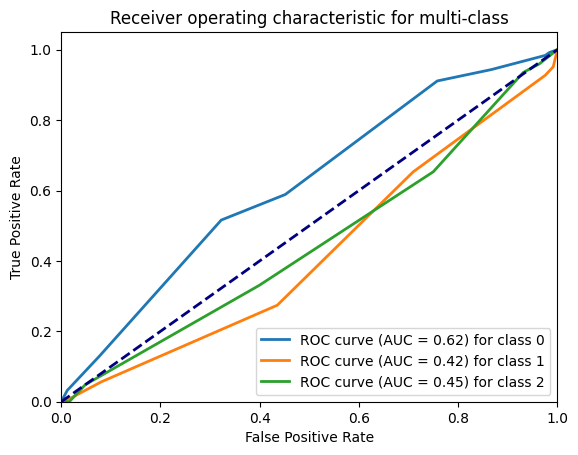

In [36]:
# Load the retrained model (model_final_droneface.pth) 
model = Backbone(50, drop_ratio=0.6, mode='ir_se')
model.load_state_dict(torch.load('D:\OneDrive\Documents\GitHub Projects\Face Recognition Project\model_final_droneface.pth', map_location=torch.device('cpu')))

def get_image_embeddings(test_images, model):
    # Set model to evaluation mode
    model.eval()

    # Reset running statistics of batch normalization layers
    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            module.reset_running_stats()

    # Pass the image through the model and flatten the output
    with torch.no_grad():
        embeddings = model(torch.stack(test_images)).view(torch.stack(test_images).size(0), -1)

    return embeddings

test_embeddings = get_image_embeddings(test_images, model)

# Compute similarity scores for all image pairs
similarity_scores = cosine_similarity([embedding.squeeze().numpy() for embedding in get_image_embeddings(test_images, model)])

# Flatten the similarity scores and integer labels arrays
similarity_scores_flat = similarity_scores.flatten()
integer_labels_flat = np.array(test_labels).flatten()

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(test_classes):
    # Treat current class as positive and the rest as negative
    y_true = np.zeros(test_labels.shape)
    y_true[test_labels == i] = 1
    # Flatten similarity scores and labels
    y_score = similarity_scores[:, i].flatten()
    y_true = y_true.flatten()
    # Compute ROC curve and AUC for current class
    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
import matplotlib.pyplot as plt
plt.figure()
lw = 2
for i in range(test_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (AUC = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()


### CMC Curve

The Cumulative Match Characteristic (CMC) curve is a way of measuring the accuracy of a biometric system. It represents the cumulative probability of a subject's true match score ranking within the top N positions of the rank-ordered list of similarity scores.

The rank-1 accuracy is a specific point on the CMC curve, where the accuracy is measured at the top rank (i.e., the subject's true match score ranking first in the rank-ordered list of similarity scores).

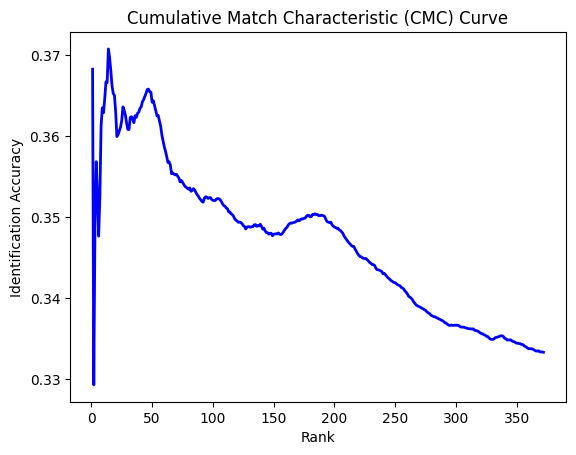

In [37]:
# Compute CMC curve and rank-1 accuracy
test_labels = np.array(test_labels)
sorted_labels = test_labels[np.argsort(similarity_scores, axis=1)[:, ::-1]]
cmc = np.cumsum(sorted_labels == test_labels.reshape(-1, 1), axis=1).astype(np.float32)
cmc /= np.arange(1, cmc.shape[1]+1, dtype=np.float32)
cmc = np.mean(cmc, axis=0)
rank1_acc = cmc[0]

# Plot CMC curve
plt.plot(range(1, len(cmc)+1), cmc, color='blue', lw=2)
plt.xlabel('Rank')
plt.ylabel('Identification Accuracy')
plt.title('Cumulative Match Characteristic (CMC) Curve')
plt.show()



## Verification Accuracy

Verification accuracy is a measure of the model's performance in correctly verifying whether two images belong to the same person. It is computed by comparing the similarity scores of image pairs against a given threshold (usually 0.5) and counting the number of correct predictions. 

A higher verification accuracy indicates a better model performance in recognizing individuals.

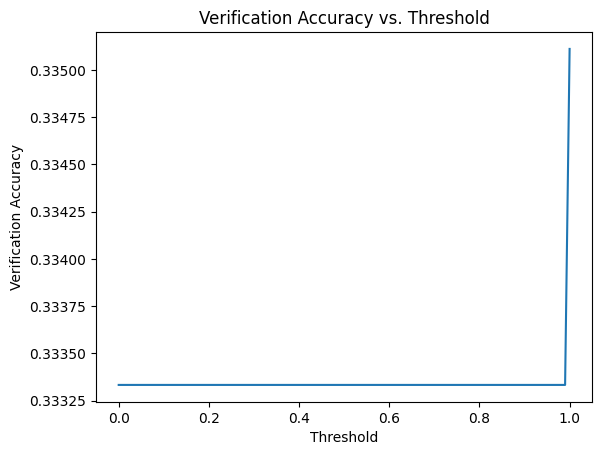

In [38]:
# Compute verification accuracy at various threshold values
verification_accuracy = []
thresholds = np.arange(0, 1.01, 0.01)
for threshold in thresholds:
    predicted_labels = (similarity_scores >= threshold).astype(int)
    accuracy = np.mean(predicted_labels == test_labels)
    verification_accuracy.append(accuracy)

# Plot verification accuracy vs. threshold
plt.plot(thresholds, verification_accuracy)
plt.xlabel('Threshold')
plt.ylabel('Verification Accuracy')
plt.title('Verification Accuracy vs. Threshold')
plt.show()
